# Исследование рынка заведений общественного питания Москвы

Необходимо исследовать рынок заведений в Москве перед открытием собственного небольшого кафе,где гостей должны обслуживать роботы

## Предобработка данных <a class="anchor" id="Предобработка-данных"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import math as mt
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 300

df = pd.read_csv('rest_data.csv')


In [2]:
df.head()
df.info()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


На первый взгляд нет пропущенных значений, все типы данных правильные. Можно только заменить тип в столбце `chain` на булев.

In [3]:
df['chain'] = df['chain'].map({'нет': bool(False), 'да': bool(True)})
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,True,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Для анализа дубликатов стоит привести все значения в столбце `object_name` к одному регистру

In [4]:
df['object_name'].value_counts()

Столовая                   267
Кафе                       236
Шаурма                     234
KFC                        155
Шоколадница                142
                          ... 
Pita Mix                     1
ШКОЛА 573 «КДП»              1
школа 338                    1
Кальянная Rodina Lounge      1
СОЛЮКС КЛАБ                  1
Name: object_name, Length: 10393, dtype: int64

In [5]:
df['object_name'] = df['object_name'].str.lower()
df['object_name'].value_counts()

столовая                 321
кафе                     278
шаурма                   250
шоколадница              158
kfc                      155
                        ... 
цыпа гриль                 1
кафе при г-це максима      1
the waiters                1
ресторан «khinka lee»      1
столовая 894               1
Name: object_name, Length: 9924, dtype: int64

In [6]:
df['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

В столбце `object_type` все типы объектов уникальны

Можно заметить, что в столбцах `object_name` и `object_type` есть совпадающие значения кафе и столовая. Если для типов заведений эти значения - категориальные, то для названий заведений эти значения - ошибочны, но на дальнейший анализ не повлияют. 

In [7]:
df['number'].value_counts()

0      1621
40      835
20      727
30      685
10      644
       ... 
172       1
520       1
680       1
760       1
495       1
Name: number, Length: 315, dtype: int64

А в столбце `number` есть более 10% нулевых значений 

In [8]:
df[(df['number'] == 0)]['object_type'].value_counts()

предприятие быстрого обслуживания    704
кафе                                 310
закусочная                           189
магазин (отдел кулинарии)            145
кафетерий                            113
буфет                                 68
ресторан                              45
бар                                   28
столовая                              19
Name: object_type, dtype: int64

Любой из представленных типов заведений может быть без посадочных мест, поэтому стоит оставить 0

Необходимо проверить, является ли заведение сетевым

In [9]:
df2 = df['object_name'].value_counts().to_frame()
df3 = df2[df2['object_name'] > 1]
df3.index # все заведения, которых больше 1 

Index(['столовая', 'кафе', 'шаурма', 'шоколадница', 'kfc', 'макдоналдс',
       'бургер кинг', 'теремок', 'крошка картошка', 'домино'с пицца',
       ...
       'джонджоли', 'ля фантази', 'клаштер', 'еда обитания', 'столовая клюква',
       'восточный дворик', 'печорин александр александрович',
       'кафе «сабвей» старбакс', 'coffee play', 'павлин-мавлин'],
      dtype='object', length=1122)

In [10]:
df[(df['object_name'].isin(df3.index)) & ((df['chain'].isin([False])))]

,id,object_name,chain,object_type,address,number
10,148595,пекарня 24,False,закусочная,"город Москва, Авиамоторная улица, дом 47",5
17,154654,донер кебаб,False,предприятие быстрого обслуживания,"город Москва, Азовская улица, дом 4",2
20,21950,кафе,False,кафе,"город Москва, Алтайская улица, дом 33/7",30
21,84832,кафе уют,False,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110
24,125608,кафетерий,False,кафетерий,"город Москва, Алтуфьевское шоссе, дом 56",6
...,...,...,...,...,...,...
15014,210231,кафе,False,кафе,"город Москва, Люблинская улица, владение 60, строение 1/1",20
15015,208239,газпромнефть,False,кафе,"поселение ""Мосрентген"", деревня Дудкино, владение 1",20
15017,205588,кофейня,False,кафетерий,"город Москва, поселение Щаповское, улица Евгения Родионова, владение 1",16
15020,208941,кальянс,False,бар,"город Москва, поселение Сосенское, бульвар Веласкеса, дом 5, корпус 3",15


Оказалось, что 3911 значений столбца `object_name` являются сетевыми, хотя в столбце `chain` написано обратное. Стоит поменять значение

In [11]:
df.loc[ ((df['object_name'].isin(df3.index)) & ((df['chain'].isin([False])))) , 'chain'] = True

Для поиска дубликатов стоит искать одинаковые значения во всех столбцах, кроме столбцов `id` и `number`

In [12]:
df[df[['object_name', 'chain', 'object_type', 'address']].duplicated() == 1]

,id,object_name,chain,object_type,address,number
115,28614,комбинат питания мгту им.н.э.баумана,True,буфет,"город Москва, Бригадирский переулок, дом 3-5",12
580,149205,общественное питание,True,кафе,"город Москва, Павелецкая площадь, дом 1",35
581,149131,общественное питание,True,кафе,"город Москва, Павелецкая площадь, дом 1",39
1409,151267,альфорно,True,кафе,"город Москва, город Зеленоград, корпус 438",45
2375,28604,комбинат питания мгту им.н.э.баумана,True,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",150
...,...,...,...,...,...,...
15173,218542,кофе с собой,True,предприятие быстрого обслуживания,"город Москва, Алтуфьевское шоссе, дом 70, корпус 1",0
15216,214468,макдоналдс,True,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 87Б",0
15217,214146,макдоналдс,True,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 13А",0
15363,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20


Нашлось 184 полных дубликатов

In [13]:
df[['object_name', 'chain', 'object_type', 'address']] = \
df[['object_name', 'chain', 'object_type', 'address']].drop_duplicates().reset_index(drop = True)

In [14]:
df = df.dropna()

In [15]:
df

,id,object_name,chain,object_type,address,number
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15177,211690,кофейня «шоколадница»,True,кафе,"город Москва, Кантемировская улица, дом 47",0
15178,210112,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",4
15179,212594,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",9
15180,221000,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",0


Изначальные данные практически не имели дубликатов и пропусков, а типы данных совпадали со значениями в столбцах, но в некоторых из них были ошибочные значения .

## Анализ данных <a class="anchor" id="Анализ-данных"></a>

In [16]:
sns.set_style("whitegrid")
sns.set_palette('husl')
sns.set_context("talk", font_scale=1, rc={"lines.linewidth":1})

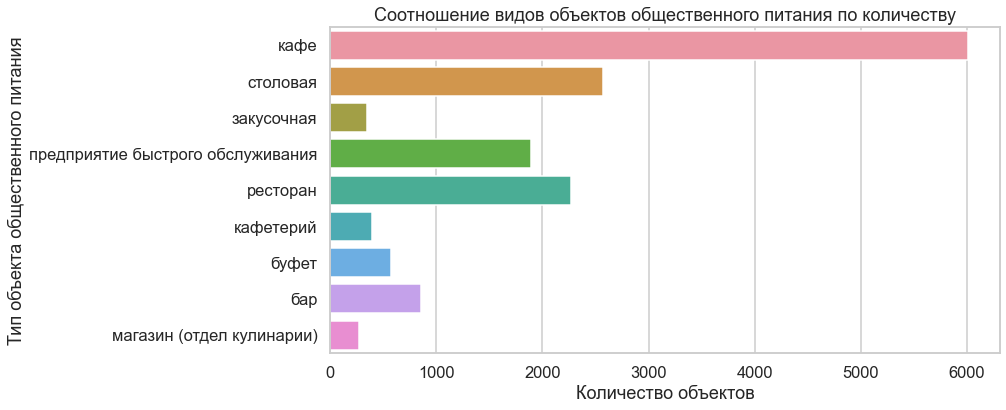

In [17]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(y = 'object_type', data = df)
ax.set_title('Соотношение видов объектов общественного питания по количеству')
ax.set_xlabel('Количество объектов')
ax.set_ylabel('Тип объекта общественного питания')
plt.show();


Больше всего заведений общественного питания находятся в категориях: кафе, столовая, ресторан и предприятие быстрого питания

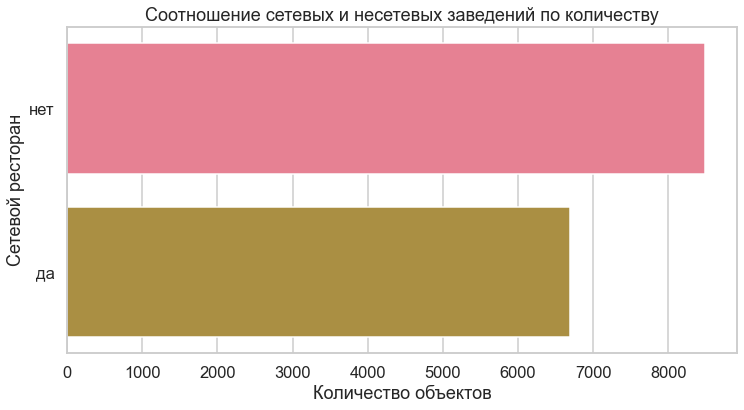

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(y = 'chain', data = df)
ax.set_title('Соотношение сетевых и несетевых заведений по количеству')
ax.set_xlabel('Количество объектов')
ax.set_ylabel('Сетевой ресторан')
ax.set_yticklabels(['нет', 'да'])
plt.show();

Несетевых ресторанов почти на 2000 больше, чем сетевых

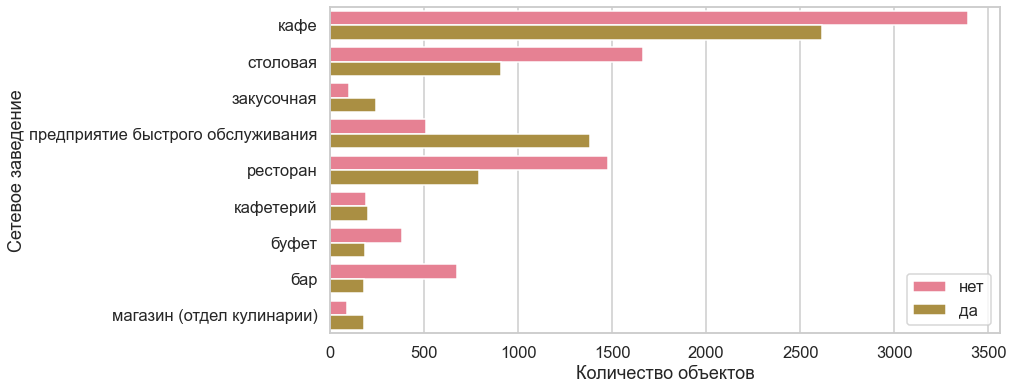

In [19]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(y = 'object_type', hue = 'chain', data = df)

ax.set_xlabel('Количество объектов')
ax.set_ylabel('Сетевое заведение')
ax.legend(['нет', 'да'])
plt.show();




Сетевое распространение больше всего характерно для закусочных, предприятий быстрого обслуживания, кафетериев и магазинов с отделом кулинарии

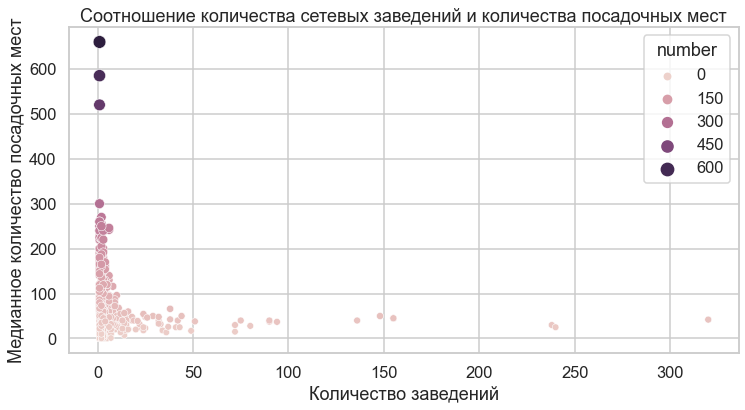

In [20]:
c_n = df[df['chain'] == True].groupby('object_name')[['id', 'number']].agg({'id': 'count', 'number': 'median'})
fig, ax = plt.subplots(figsize = (12, 6))
sns.scatterplot(data = c_n, x = c_n['id'], y = c_n['number'], hue = 'number', size = 'number')
ax.set_title('Соотношение количества сетевых заведений и количества посадочных мест')
ax.set_xlabel('Количество заведений')
ax.set_ylabel('Медианное количество посадочных мест')

plt.show();


На графике видно, что в основном для сетевых заведений характерно небольшое количество самих заведений, но большое количество посадочных мест

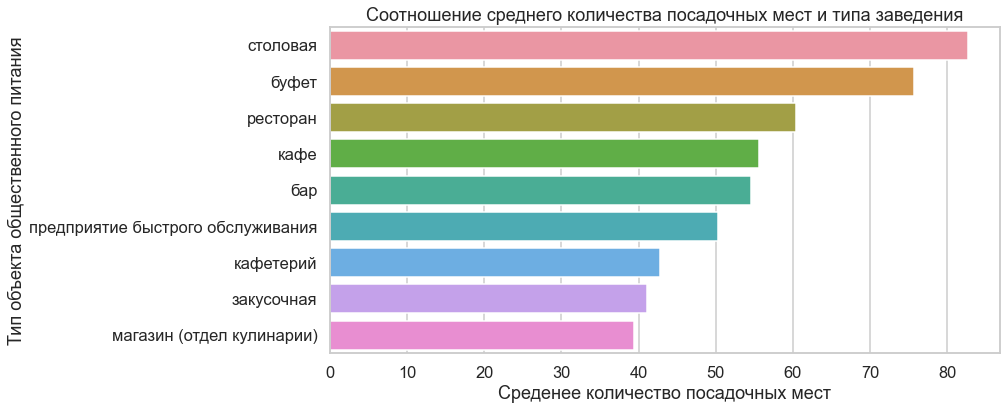

In [21]:
mean_type = (df.groupby('object_type')['number'].agg(['mean'])).sort_values('mean', ascending= False)
mean_type

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = mean_type, y = mean_type['mean'].index, x = mean_type['mean'].values)
ax.set_title('Соотношение среднего количества посадочных мест и типа заведения')
ax.set_xlabel('Среденее количество посадочных мест')
ax.set_ylabel('Тип объекта общественного питания')
plt.show();


В среднем самое большое количество посадочных мест у столовых и буфетов

Для анализа адреса сначала необходимо узнать, в каких значениях адреса есть улица или ее аналоги

In [22]:
df[df['address'].str.contains('улица|авеню|переулок|проспект|проезд|Проезд|аллея|бульвар|набережная\
|площадь|просека|спуск|тупик|шоссе|линия')]

,id,object_name,chain,object_type,address,number
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15177,211690,кофейня «шоколадница»,True,кафе,"город Москва, Кантемировская улица, дом 47",0
15178,210112,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",4
15179,212594,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",9
15180,221000,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",0


В 14789 строках есть улицы, в остальных строках адрес неточный, их можно удалить 

In [23]:
df = df[df['address'].str.contains('улица|авеню|переулок|проспект|проезд|Проезд|аллея|бульвар|набережная\
|площадь|просека|спуск|тупик|шоссе|линия')]

In [24]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def street_func(string):
    st = re.split(r', |\n', string)
    for i in st:
        if ('улица' in i or 'авеню' in i or 'переулок' in i or 'проспект' in i
            or 'проезд' in i or 'Проезд' in i or 'аллея' in i or 'бульвар' in i 
            or 'набережная' in i or 'площадь' in i or 'просека' in i or 'спуск' in i
            or 'тупик' in i or 'шоссе' in i or 'линия' in i):
                return(i)
        
        
    
df['street_name'] = df['address'].apply(street_func) 
df

,id,object_name,chain,object_type,address,number,street_name
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15177,211690,кофейня «шоколадница»,True,кафе,"город Москва, Кантемировская улица, дом 47",0,Кантемировская улица
15178,210112,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",4,улица Вавилова
15179,212594,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",9,3-й Крутицкий переулок
15180,221000,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",0,улица Земляной Вал


Все улицы и ее аналоги добавлены в отдельный столбец

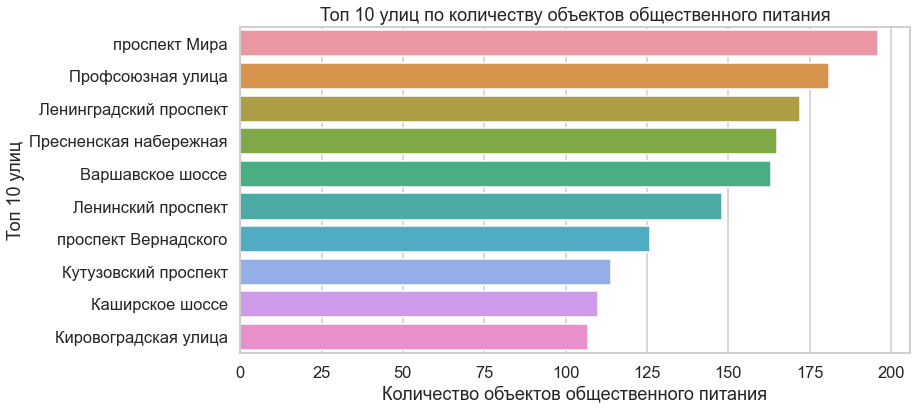

In [25]:
top10 = df['street_name'].value_counts().head(10)
top10 = pd.DataFrame(top10).reset_index()

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = top10, y = top10['index'], x = top10['street_name'])
ax.set_title('Топ 10 улиц по количеству объектов общественного питания')
ax.set_xlabel('Количество объектов общественного питания')
ax.set_ylabel('Топ 10 улиц')
plt.show();

Топ 10 улиц по количеству по количеству объектов общественного питания. Теперь можно найти районы, в которых находятся эти улицы

In [26]:
temp_df = pd.read_csv('mosgaz-streets.csv')
temp_df = temp_df[['streetname', 'area']].rename(columns = {'streetname': 'street_name'})
temp_df

,street_name,area
0,Выставочный переулок,Пресненский район
1,улица Гашека,Пресненский район
2,Большая Никитская улица,Пресненский район
3,Глубокий переулок,Пресненский район
4,Большой Гнездниковский переулок,Пресненский район
...,...,...
4393,Вознесенский проезд,Пресненский район
4394,Волков переулок,Пресненский район
4395,Поварская улица,Пресненский район
4396,Кудринская площадь,Пресненский район


In [27]:
top10_list = []
top10_first_list = []
for i in top10['index']:
    top10_list.append(df[df['address'].str.contains(i)])
    top10_first_list.append(df[df['address'].str.contains(i)].iloc[0].to_frame().T)
    
top10_df = pd.concat(top10_list).reset_index(drop = True)
top10_df_first_title = pd.concat(top10_first_list).reset_index(drop = True)

In [28]:
top10_df_first_title

,id,object_name,chain,object_type,address,number,street_name
0,25816,сухарева башня,False,кафе,"город Москва, проспект Мира, дом 5, корпус 1",25,проспект Мира
1,108858,стардогs,True,предприятие быстрого обслуживания,"город Москва, Профсоюзная улица, дом 2/22",48,Профсоюзная улица
2,20804,фортутти,False,кафе,"город Москва, Ленинградский проспект, дом 2",16,Ленинградский проспект
3,26705,ресторан «sixty»,False,ресторан,"город Москва, Пресненская набережная, дом 12",90,Пресненская набережная
4,24155,кафе «андерсон»,True,кафе,"город Москва, Варшавское шоссе, дом 2",82,Варшавское шоссе
5,149227,шаурма,True,предприятие быстрого обслуживания,"город Москва, Ленинский проспект, дом 2А",70,Ленинский проспект
6,128946,пироговая рогова,False,кафе,"город Москва, проспект Вернадского, дом 9/10",3,проспект Вернадского
7,25124,шёлковый путь,False,ресторан,"город Москва, Кутузовский проспект, дом 71",35,Кутузовский проспект
8,148070,чайхона 7-24,False,кафе,"город Москва, Каширское шоссе, дом 5, корпус 1",35,Каширское шоссе
9,143454,гостиница эмос,False,столовая,"город Москва, Кировоградская улица, дом 11",60,Кировоградская улица


In [29]:
merge_df = top10_df_first_title.merge(temp_df, left_on='street_name', right_on='street_name')
merge_df['area'] = (merge_df['area']) + ' '

In [30]:
merge_df.groupby('street_name')['area'].sum().to_frame()

,area
street_name,
Варшавское шоссе,Район Чертаново Центральное Район Чертаново Северное Район Чертаново Южное Донской район Район Нагатино-Садовники Нагорный район Район Северное Бутово Район Южное Бутово
Каширское шоссе,Район Москворечье-Сабурово Район Нагатино-Садовники Район Орехово-Борисово Южное Район Орехово-Борисово Северное
Кировоградская улица,Район Чертаново Центральное Район Чертаново Северное Район Чертаново Южное
Кутузовский проспект,Район Дорогомилово Район Фили-Давыдково
Ленинградский проспект,Район Аэропорт Район Беговой Хорошевский район Район Сокол
Ленинский проспект,Район Проспект Вернадского Район Тропарево-Никулино Донской район Район Гагаринский Ломоносовский район Обручевский район Район Теплый Стан Район Якиманка
Пресненская набережная,Пресненский район
Профсоюзная улица,Академический район Район Черемушки Район Ясенево Район Коньково Обручевский район Район Теплый Стан
проспект Вернадского,Район Проспект Вернадского Район Раменки Район Тропарево-Никулино Район Гагаринский Ломоносовский район


Все районы, в которых находятся топ 10 улиц по количеству объектов общественного питания

Теперь нужно найти улицы с одним объектом общественного питания

In [31]:
one_rest = df['street_name'].value_counts().reset_index()
one_rest[one_rest['street_name'] == 1]['index'].count()

549

На 549 улицах находится всего по одному такому объекту

In [32]:
one_rest = one_rest[one_rest['street_name'] == 1]

In [33]:
one_rest_list = []
for i in one_rest['index']:
    one_rest_list.append(df[df['street_name'] == str(i)])        
one_rest = pd.concat(one_rest_list).reset_index(drop = True)
one_rest


,id,object_name,chain,object_type,address,number,street_name
0,197153,чайхона vizir,False,кафе,"город Москва, 2-я улица Марьиной Рощи, дом 22",0,2-я улица Марьиной Рощи
1,22389,ribambelle,True,ресторан,"город Москва, Ботанический переулок, дом 5",40,Ботанический переулок
2,106130,сабрина,True,кафе,"город Москва, Аэрофлотская улица, владение 2Б",25,Аэрофлотская улица
3,82620,оазис,True,кафе,"город Москва, улица Рокотова, дом 2А",120,улица Рокотова
4,19650,столовая,True,столовая,"город Москва, 2-й Рощинский проезд, дом 8",25,2-й Рощинский проезд
...,...,...,...,...,...,...,...
544,24401,гбоу школа № 1352,True,столовая,"город Москва, Новосибирская улица, дом 8",45,Новосибирская улица
545,85416,кафе торшер,False,кафе,"город Москва, улица Васильцовский Стан, дом 5, корпус 1",40,улица Васильцовский Стан
546,23242,кафе гор,False,кафе,"город Москва, Сибирский проезд, дом 2, корпус 27, строение 1",200,Сибирский проезд
547,179011,столовая,True,столовая,"город Москва, 2-й Балтийский переулок, дом 3",34,2-й Балтийский переулок


In [34]:
merge_df = one_rest.merge(temp_df, left_on='street_name', right_on='street_name')

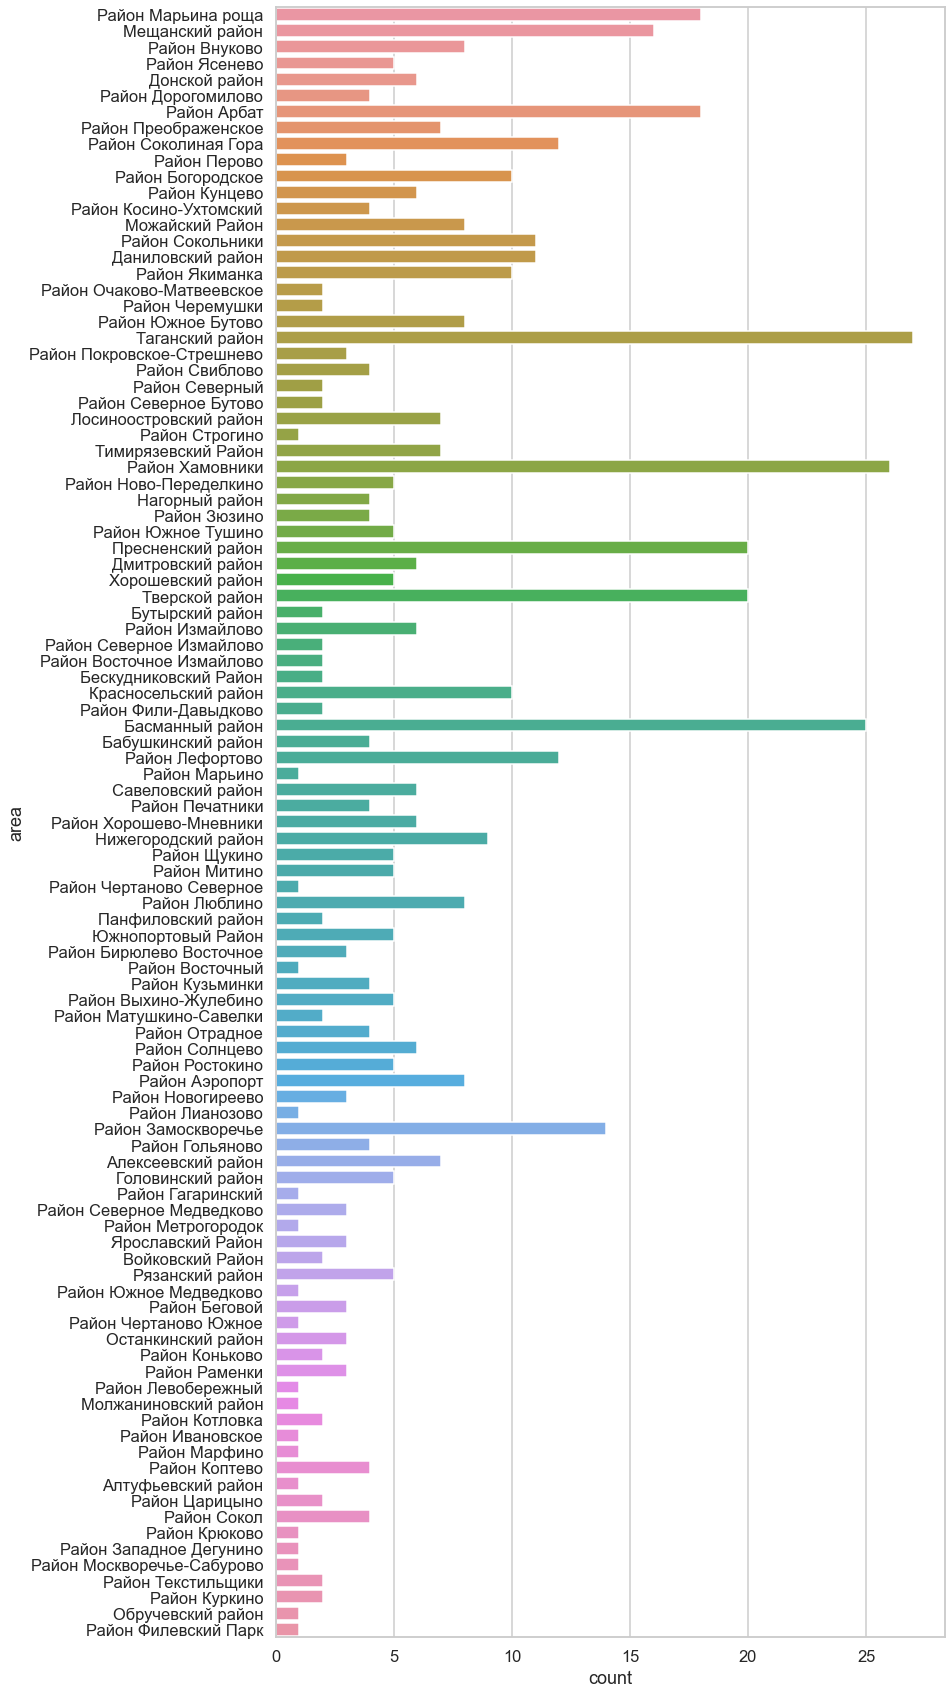

In [35]:
fig,  ax = plt.subplots(figsize = (12, 30))
sns.countplot(data = merge_df, y = 'area')
plt.show();

Все районы, на улицах которых есть только один объект общественного питания 

Теперь нужно понять, как распределены посадочные места на улицах с большим количеством объектов общественного питания

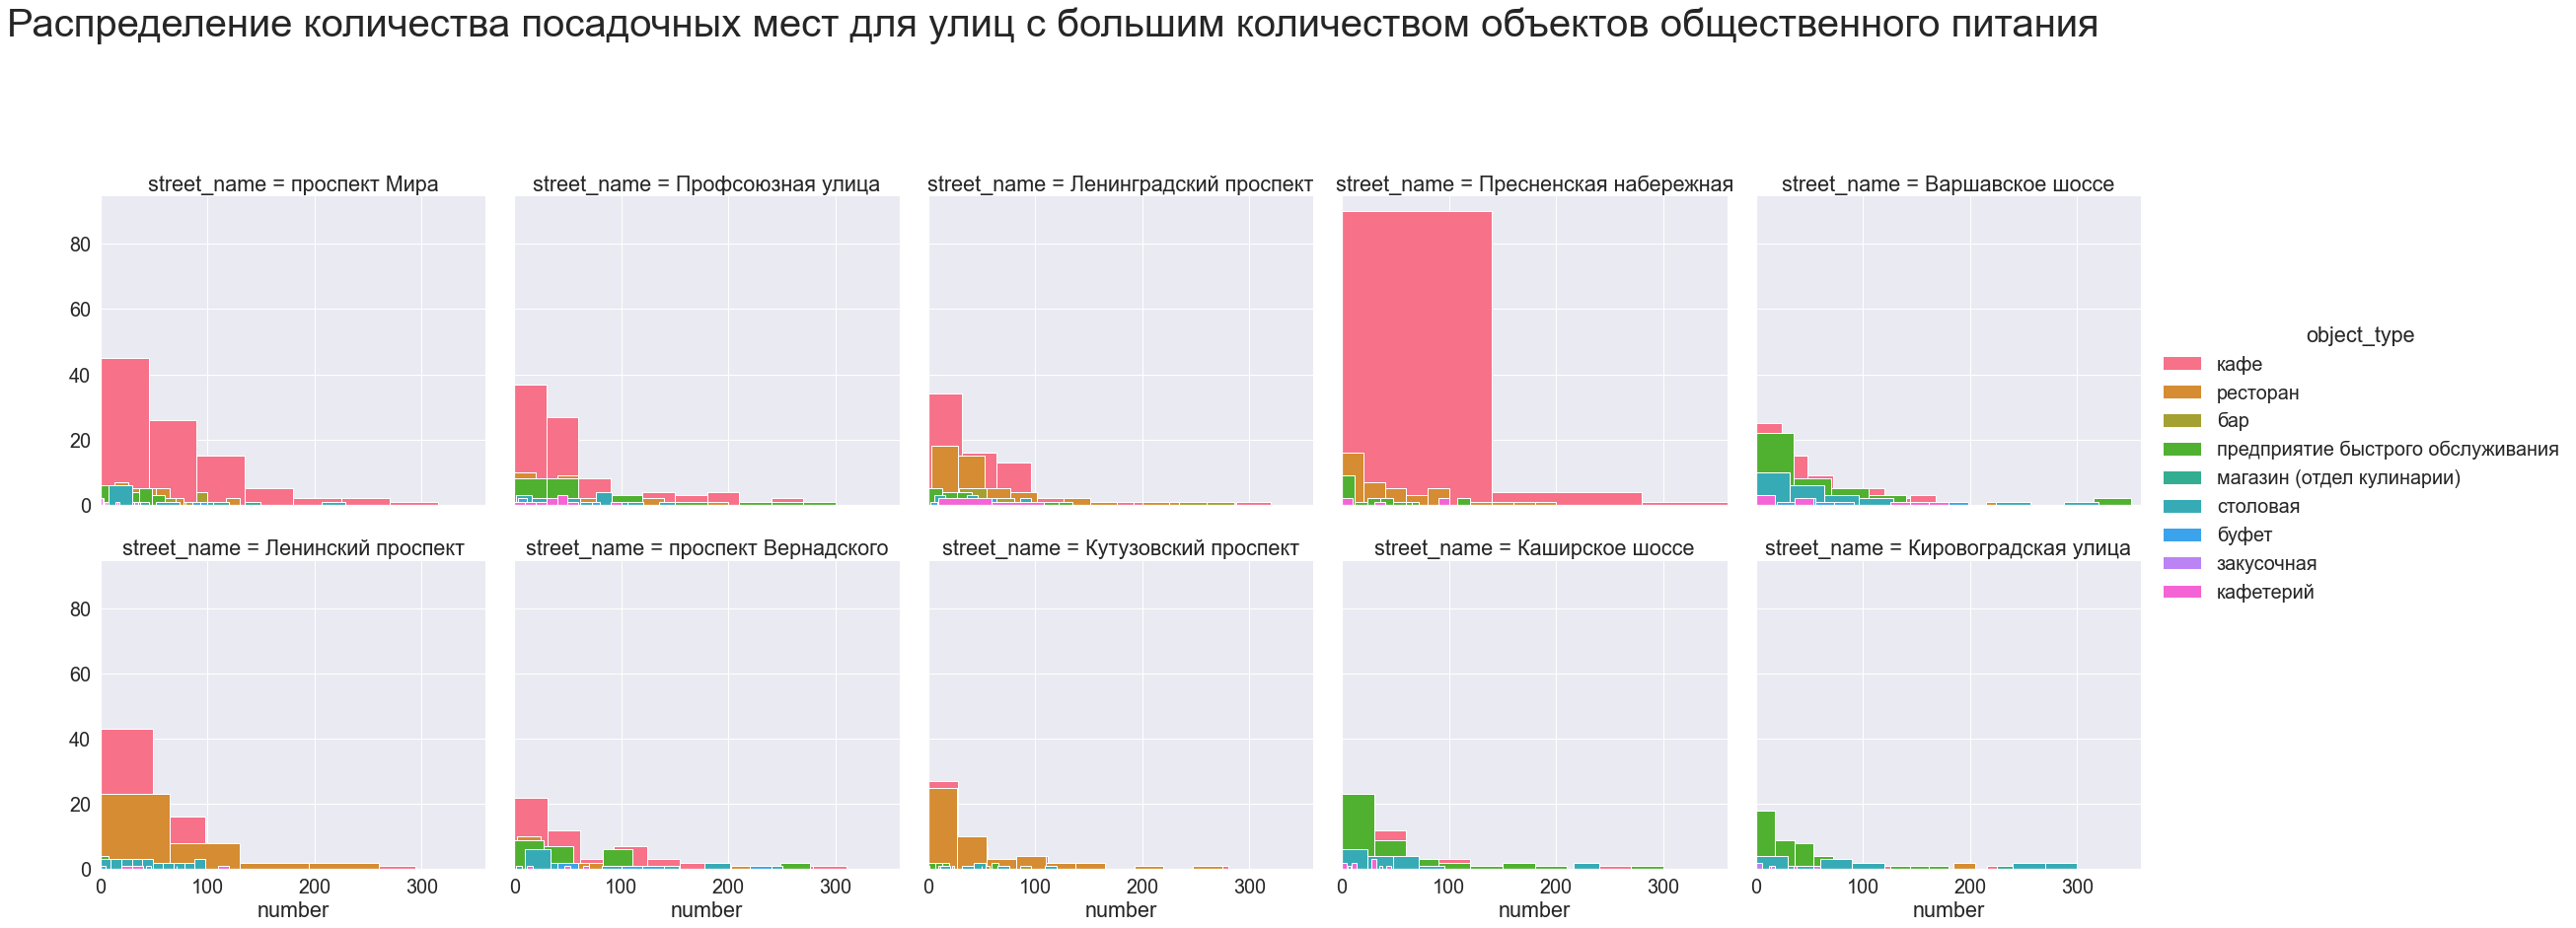

In [36]:
sns.set(font_scale=1.8)
g = sns.FacetGrid(top10_df, height = 6, legend_out = True,
                  palette='husl', 
                  hue='object_type',
                  col='street_name', col_wrap=5, 
                  )

g.set(xlim=(0, 360))
g.fig.suptitle(x = 0.4, y = 1.1, t = 'Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания', fontsize=40)
g.map(plt.hist, 'number').add_legend()
plt.show();

- БОльшим количеством мест обладают кафе, однако на Кутузовском проспекте больше всего ресторанов, а на Каширском шоссе и Кировоградской улице больше всего фастфудов
- Минимальное количество посадочных мест почти на всех графиках - у кафетериев, закусочных и магазинов
- Основное количество всех мест на этих улицах - от 0 до 100

## Вывод <a class="anchor" id="Вывод-2"></a>

- Чтобы избежать сильной конкуренции, желательно не открывать кафе, ресторан, столовую или фастфуд, потому что этих заведений большинство 
- Для быстрого роста необходим большой поток людей и большое количество посадочных мест, поэтому кафетерии, закусочные и магазины с отделами кулинарии не подойдут
- Остаются бары и буфеты, их необходимо открывать, с одной стороны, на улицах из топ 10, но с другой стороны, не на самых популярных, поэтому подойдут Кутузовский проспект, Каширское шоссе и Кировоградская улица 
- Таким образом, лучшие варианты - это бар или буфет в следующих районах Москвы: 
    * Москворечье-Сабурово, Нагатино-Садовники, Орехово-Борисово Южное и Северное 
    * Чертаново Центральное, Северное и Южное
    * Дорогомилово, Фили-Давыдково

## Презентация <a class="anchor" id="Презентация"></a>

Презентация: https://docs.google.com/presentation/d/1fz77RBii6Mf0lIHE1-khdwk4eDijbaQBhN8U_j9ZbzI/edit?usp=sharing